In [1]:
import pandas as pd
import numpy as np
import requests
import json
import pprint
from collections import defaultdict
import glob

# <font color='#0366d6'> REA realestate.com.au | suburb | property median price data <font>
- Access API data 

In [2]:
# A list of suburb to scrape the house buy and rent data from realestate.com.au
suburbs=['runcorn','sunnybank','sunnybank hills','eight mile plains', 
         'kuraby', 'upper mount gravatt', 'wishart', 'coopers plains','calamvale', 'algester']

In [3]:
#Create a loop to collect the house buy and rent data from each suburb

results=[]

for s in suburbs:
    #define API URL
    url_part1='https://investor-api.realestate.com.au/v2/states/qld/suburbs/'
    url_part2='.json?embed=suburb_geo'

    url=url_part1+s+url_part2
    
    #Request the URL and parse the JSON data
    response=requests.get(url) #request the url
    response.raise_for_status() #raise exception if invaid response
    #print('Response Code: ',response.status_code) #check the request code  

    result=response.json() #create a json object ofthe results
    results.append(result)

In [4]:
#check if the results list has collected all 10 suburbs data from the json file
suburb_keys=[list(r.keys())[0] for r in results] 
print(suburb_keys)

['RUNCORN-4113', 'SUNNYBANK-4109', 'SUNNYBANK HILLS-4109', 'EIGHT MILE PLAINS-4113', 'KURABY-4112', 'UPPER MOUNT GRAVATT-4122', 'WISHART-4122', 'COOPERS PLAINS-4108', 'CALAMVALE-4116', 'ALGESTER-4115']


In [5]:
#Preview a sample suburb "Runcorn" json data
#pprint.pprint(results[1]) #print the result

## Create a suburb based house price data frame

In [6]:
property_type=results[0]['RUNCORN-4113']['property_types'] #check what property types available in the listing
print(property_type.keys()) #2 Types - House, Unit

#We only look for bedrooms with 3+ bedrooms
house_bed_num=['ALL', '3', '4', '5+']

dict_keys(['HOUSE', 'UNIT'])


In [7]:
#Create a loop to access the house buy/rent data based on the num of bedrooms from each suburb
house_bedrooms_data=[]

for key in range(len(suburb_keys)):
    
    suburbs_pc=suburb_keys[key]  #suburb name + postal_code
    suburb_data=results[key][suburbs_pc] #access the suburb dict
    house_suburb_data=suburb_data['property_types']['HOUSE'] #access the house data in the dict
    house_bedrooms=house_suburb_data['bedrooms'] #access the house bedrooms info in the dict
    
    hbk=list(house_bedrooms.keys()) #check if the suburb has house data with less than 3 bedrooms, if so, remove them
    if '0' in hbk:  #remove record with bedroom num=0
        house_bedrooms.pop('0')
    elif '1' in hbk: #remove record with bedroom num=1
        house_bedrooms.pop('1')
    elif '2' in hbk:#remove record with bedroom num=2
        house_bedrooms.pop('2')
    else:
        house_bedrooms
    
    house_bedrooms_data.append(house_bedrooms)    

In [8]:
# Buid a house buy and rent dataframe based on the num of bedrooms from each suburb

df_houses_list=[]
for i in range(10):
    suburb=suburbs[i]
    house_data=house_bedrooms_data[i]
    
    houses_data_list=[]
    
    for x in range(4): #use loop to return the house data based on the num of bedrooms (num=3,4, 5+ or ALL)
        num=house_bed_num[x]
        houses_data=house_data[num]['investor_metrics']
            
        houses_data['bedrooms']=num # add a new column to show the bedroom number
        df_houses=pd.DataFrame(houses_data, index=np.arange(1))#store the house data in a dataframe
        houses_data_list.append(df_houses) #append all house dfs for a suburb into a list


    df_houses=pd.concat(houses_data_list,axis=0, ignore_index=True) #merge all dataframes in the list into 1 for each suburb

    df_houses['suburb']=str(suburb) #add a new colum to show the suburb name

    cols=df_houses.columns.to_list() # 10 columns
    cols=cols[-1:]+cols[-2:-1]+cols[:-2] #move the last 2 colunns ("suburb, bedrooms") to the front of dataframe
    df_houses=df_houses[cols]
    df_houses_list.append(df_houses) #append all suburb unit dfs into a list
    

df_houses=pd.concat(df_houses_list,axis=0, ignore_index=True) #merge all suburb dataframes into 1
df_houses['property_type']='house'
df_houses.head()    


,suburb,bedrooms,median_sold_price,median_sold_price_five_years_ago,median_rental_price,rental_yield,annual_growth,rental_demand,rental_properties,sold_properties,sold_properties_five_years_ago,property_type
0,runcorn,ALL,569000.0,523500,420.0,0.038383,0.017,742.58,220,78,174,house
1,runcorn,3,552000.0,485000,390.0,0.036739,0.026,821.38,105,31,86,house
2,runcorn,4,615000.0,550000,467.5,0.039529,0.023,828.09,90,33,58,house
3,runcorn,5+,766500.0,640000,530.0,0.035956,0.037,2015.98,18,6,14,house
4,sunnybank,ALL,755000.0,690000,430.0,0.029616,0.018,597.14,260,59,147,house


In [9]:
df_houses.dtypes # we noticed that "median_sold_price_five_years_ago" and "annual_growth" are shown as string

suburb                               object
bedrooms                             object
median_sold_price                   float64
median_sold_price_five_years_ago     object
median_rental_price                 float64
rental_yield                        float64
annual_growth                        object
rental_demand                       float64
rental_properties                     int64
sold_properties                       int64
sold_properties_five_years_ago        int64
property_type                        object
dtype: object

In [10]:
df_houses.isnull().sum() #check if there are null values

suburb                              0
bedrooms                            0
median_sold_price                   0
median_sold_price_five_years_ago    1
median_rental_price                 0
rental_yield                        0
annual_growth                       1
rental_demand                       0
rental_properties                   0
sold_properties                     0
sold_properties_five_years_ago      0
property_type                       0
dtype: int64

In [11]:
df_houses.fillna(0, inplace=True) #replace null value with 0
df_houses.head()

,suburb,bedrooms,median_sold_price,median_sold_price_five_years_ago,median_rental_price,rental_yield,annual_growth,rental_demand,rental_properties,sold_properties,sold_properties_five_years_ago,property_type
0,runcorn,ALL,569000.0,523500.0,420.0,0.038383,0.017,742.58,220,78,174,house
1,runcorn,3,552000.0,485000.0,390.0,0.036739,0.026,821.38,105,31,86,house
2,runcorn,4,615000.0,550000.0,467.5,0.039529,0.023,828.09,90,33,58,house
3,runcorn,5+,766500.0,640000.0,530.0,0.035956,0.037,2015.98,18,6,14,house
4,sunnybank,ALL,755000.0,690000.0,430.0,0.029616,0.018,597.14,260,59,147,house


In [12]:
#convert "median_sold_price_five_years_ago" and "annual_growth" into float data types
dict={"suburb":str, "bedrooms":str,
      "median_sold_price":np.float64,
     "median_sold_price_five_years_ago":np.float64,
     "median_rental_price":np.float64,
      "annual_growth":np.float64,
      "rental_demand":np.float64,
      "rental_properties":np.int64,
      "sold_properties":np.int64,
      "sold_properties_five_years_ago":np.int64,
      "property_type": str}

In [13]:
#check the data type again
df_houses.apply(dict)
df_houses.dtypes

suburb                               object
bedrooms                             object
median_sold_price                   float64
median_sold_price_five_years_ago    float64
median_rental_price                 float64
rental_yield                        float64
annual_growth                       float64
rental_demand                       float64
rental_properties                     int64
sold_properties                       int64
sold_properties_five_years_ago        int64
property_type                        object
dtype: object

In [14]:
df_rea_data=df_houses
df_rea_data.rename({'property_type':'type'},axis=1, inplace=True)
df_rea_data.head()

,suburb,bedrooms,median_sold_price,median_sold_price_five_years_ago,median_rental_price,rental_yield,annual_growth,rental_demand,rental_properties,sold_properties,sold_properties_five_years_ago,type
0,runcorn,ALL,569000.0,523500.0,420.0,0.038383,0.017,742.58,220,78,174,house
1,runcorn,3,552000.0,485000.0,390.0,0.036739,0.026,821.38,105,31,86,house
2,runcorn,4,615000.0,550000.0,467.5,0.039529,0.023,828.09,90,33,58,house
3,runcorn,5+,766500.0,640000.0,530.0,0.035956,0.037,2015.98,18,6,14,house
4,sunnybank,ALL,755000.0,690000.0,430.0,0.029616,0.018,597.14,260,59,147,house


# <font color='#0366d6'> Domain.com.au | suburb | property median price data </font>
- Access data collected by using a web scraper 

Note: Unlike **REA** (https://www.realestate.com.au), where the median price can be accessed directly from the page or API, <br>**Domain.com.au** (https://www.domain.com.au) shows some of the detailed property data (such as yearly median price trend) in a folded menu, which is more difficult and time consuming to scrape using Python. 

Hence I used a web scraping tool to obtain the property data only from 10 suburbs to speed up the process.<br>
Let's import the data from domain.com.au and have a preview.

In [15]:
#1. Market Trend Data

In [16]:
domain_url=r"data\domain_market_trend.xlsx"
df_domain_data=pd.read_excel(domain_url,sheet_name='mkt_trend_all')
df_domain_data.head(5)

,suburb,bedrooms,type,median_sold_price,Avg days on market,Clearance rate,sold_properties
0,runcorn,2,house,-,-,-,5
1,runcorn,3,house,$455k,67 days,0.5,58
2,runcorn,4,house,$611k,50 days,0.41,48
3,runcorn,5,house,-,-,-,8
4,runcorn,2,unit,-,-,-,3


Let's drop rows where the "Median price", "Avg days on market", and "Clearance rate" are missing. <br>
As most of them are from the property type (Unit) and bedrooms (less than 3 or greater than 5) that we are not interested.

In [17]:
#First, replace any cells containing "-" in these 3 columns with NaN value

cols_with_dash=["median_sold_price", "Avg days on market", "Clearance rate"]

for x in cols_with_dash:
    df_domain_data[x]=df_domain_data[x].replace("-", np.nan)
    
df_domain_data.head()

,suburb,bedrooms,type,median_sold_price,Avg days on market,Clearance rate,sold_properties
0,runcorn,2,house,NaN,NaN,NaN,5
1,runcorn,3,house,$455k,67 days,0.50,58
2,runcorn,4,house,$611k,50 days,0.41,48
3,runcorn,5,house,NaN,NaN,NaN,8
4,runcorn,2,unit,NaN,NaN,NaN,3


In [18]:
#Second, drop all rows where NaN values are found in the 3 columns
df_domain_data.dropna(subset=["median_sold_price", "Avg days on market","Clearance rate"], how='any', inplace=True)
df_domain_data=df_domain_data.reset_index(drop=True)
df_domain_data.head()

,suburb,bedrooms,type,median_sold_price,Avg days on market,Clearance rate,sold_properties
0,runcorn,3,house,$455k,67 days,0.50,58
1,runcorn,4,house,$611k,50 days,0.41,48
2,eight mile plains,4,house,$750k,54 days,0.43,31
3,eight mile plains,5,house,$852k,70 days,0.06,30
4,sunnybank,3,house,$655k,169 days,0.08,27


In [19]:
#check data types
#We noticed that "median_sold_price", "Avg days on market" need to updated to numeric values.
df_domain_data.dtypes

suburb                 object
bedrooms                int64
type                   object
median_sold_price      object
Avg days on market     object
Clearance rate        float64
sold_properties         int64
dtype: object

In [20]:
#remove the dollar $, texts such as days, so wecan convert these 2 cols into numeric values
from string import digits
digits+="."
print(digits)

0123456789.


In [21]:
def remove_puncs(string_piece):
    if string_piece:
        string=str(string_piece).strip()
        string =''.join([num for num in string if num in digits])
        return string

In [22]:
string_cols=["median_sold_price", "Avg days on market"]
numeric_cols = defaultdict(pd.Series)

for col in string_cols:
    numeric_cols[col]=df_domain_data[col].apply(lambda x: pd.to_numeric(remove_puncs(x), 'coerce')).astype(np.float64)

In [23]:
numeric_cols.keys()    

dict_keys(['median_sold_price', 'Avg days on market'])

In [24]:
df_domain_data=df_domain_data.drop(list(numeric_cols.keys()), axis=1)
df_domain_data.head()

,suburb,bedrooms,type,Clearance rate,sold_properties
0,runcorn,3,house,0.50,58
1,runcorn,4,house,0.41,48
2,eight mile plains,4,house,0.43,31
3,eight mile plains,5,house,0.06,30
4,sunnybank,3,house,0.08,27


In [25]:
df_domain_data=df_domain_data.assign(**numeric_cols)
df_domain_data['median_sold_price']=df_domain_data['median_sold_price']*1000 
df_domain_data.iloc[6,5]=df_domain_data.iloc[6,5]*1000 #this is a house type with 1.2M as meidan price

In [26]:
df_domain_data.head(7)

,suburb,bedrooms,type,Clearance rate,sold_properties,median_sold_price,Avg days on market
0,runcorn,3,house,0.50,58,455000.0,67.0
1,runcorn,4,house,0.41,48,611000.0,50.0
2,eight mile plains,4,house,0.43,31,750000.0,54.0
3,eight mile plains,5,house,0.06,30,852000.0,70.0
4,sunnybank,3,house,0.08,27,655000.0,169.0
5,sunnybank,4,house,0.41,28,725000.0,96.0
6,sunnybank,5,house,0.20,14,1020000.0,151.0


# <font color='#0366d6'> Which sites should we rely on? REA vs DOMAIN </font>

Through a quick check on the median house prices collected from REA and Domain, we noticed there's a big difference between the median sold price for Runcorn (3 bedroom house) from these 2 sites.<br>
-  REA | Runcorn | House | 3 Bedrooms | Median House Price - 550K <br> 
-  Domain | Runcorn | House |3 Bedrooms | Median House Price - 455K <br> 	

So let's compare the median sold price differences between REA and Domain for houses (w/ 3-4 bedrooms), which is what our clients are most intersted in.
Then decide which site we should rely on in the future to check more detailed property info.<br>

### Compare Median Price of House with 3 and 4 bedrooms  

In [27]:
# REA data

In [28]:
#First, read in the REA data again
df_rea_data.head()

,suburb,bedrooms,median_sold_price,median_sold_price_five_years_ago,median_rental_price,rental_yield,annual_growth,rental_demand,rental_properties,sold_properties,sold_properties_five_years_ago,type
0,runcorn,ALL,569000.0,523500.0,420.0,0.038383,0.017,742.58,220,78,174,house
1,runcorn,3,552000.0,485000.0,390.0,0.036739,0.026,821.38,105,31,86,house
2,runcorn,4,615000.0,550000.0,467.5,0.039529,0.023,828.09,90,33,58,house
3,runcorn,5+,766500.0,640000.0,530.0,0.035956,0.037,2015.98,18,6,14,house
4,sunnybank,ALL,755000.0,690000.0,430.0,0.029616,0.018,597.14,260,59,147,house


In [29]:
#group the rea data by 3 cols to view the house median_sold_price from each suburb
groups_rea=df_rea_data.groupby(['type','bedrooms','suburb'])['median_sold_price'].mean()
groups_rea

type   bedrooms  suburb             
house  3         algester                491000.0
                 calamvale               554750.0
                 coopers plains          550000.0
                 eight mile plains       607550.0
                 kuraby                  427750.0
                 runcorn                 552000.0
                 sunnybank               655000.0
                 sunnybank hills         554000.0
                 upper mount gravatt     630000.0
                 wishart                 637500.0
       4         algester                560500.0
                 calamvale               650000.0
                 coopers plains          668000.0
                 eight mile plains       754000.0
                 kuraby                  681000.0
                 runcorn                 615000.0
                 sunnybank               765000.0
                 sunnybank hills         658000.0
                 upper mount gravatt     695000.0
             

Because our clients are most interested in houses with 3 or 4 bedrooms, let's extract the data from the grouped view.

In [30]:
# REA House Median Price - 3 or 4 bedroms

rea_bdrs=groups_rea.loc[('house',('3','4'))] #select property type=house,bedrooms =3 or 4
rea_bdrs=rea_bdrs.sort_index(level=(0,1,2)) #sort the multi-index series by ascending order for calculation later
rea_bdrs

type   bedrooms  suburb             
house  3         algester               491000.0
                 calamvale              554750.0
                 coopers plains         550000.0
                 eight mile plains      607550.0
                 kuraby                 427750.0
                 runcorn                552000.0
                 sunnybank              655000.0
                 sunnybank hills        554000.0
                 upper mount gravatt    630000.0
                 wishart                637500.0
       4         algester               560500.0
                 calamvale              650000.0
                 coopers plains         668000.0
                 eight mile plains      754000.0
                 kuraby                 681000.0
                 runcorn                615000.0
                 sunnybank              765000.0
                 sunnybank hills        658000.0
                 upper mount gravatt    695000.0
                 wishart        

In [31]:
#Domain data

In [32]:
#Read in domain data again
df_domain_data.head()

,suburb,bedrooms,type,Clearance rate,sold_properties,median_sold_price,Avg days on market
0,runcorn,3,house,0.50,58,455000.0,67.0
1,runcorn,4,house,0.41,48,611000.0,50.0
2,eight mile plains,4,house,0.43,31,750000.0,54.0
3,eight mile plains,5,house,0.06,30,852000.0,70.0
4,sunnybank,3,house,0.08,27,655000.0,169.0


In [33]:
#group the rea data by 3 cols to view the house median_sold_price from each suburb
groups_domain=df_domain_data.groupby(['type','bedrooms','suburb'])['median_sold_price'].mean()
groups_domain

type   bedrooms  suburb             
house  3         algester                477000.0
                 runcorn                 455000.0
                 sunnybank               655000.0
                 sunnybank hills         550000.0
                 upper mount gravatt     600000.0
                 wishart                 652000.0
       4         calamvale               641000.0
                 eight mile plains       750000.0
                 kuraby                  653000.0
                 runcorn                 611000.0
                 sunnybank               725000.0
                 sunnybank hills         660000.0
                 upper mount gravatt     709000.0
                 wishart                 789000.0
       5         calamvale               775000.0
                 eight mile plains       852000.0
                 sunnybank              1020000.0
                 sunnybank hills         873000.0
                 wishart                 958000.0
Name: median_

Because our clients are most interested in houses with 3 or 4 bedrooms, let's extract the data from Domain as well

In [34]:
# Domain House Median Price - 3 or 4 bedroms

domain_bdrs=groups_domain.loc[('house',(3,4))]  #select property type=house,bedrooms =3 or 4
domain_bdrs=domain_bdrs.sort_index(level=(0,1,2))  #select property type=house,bedrooms =3 or 4
domain_bdrs

type   bedrooms  suburb             
house  3         algester               477000.0
                 runcorn                455000.0
                 sunnybank              655000.0
                 sunnybank hills        550000.0
                 upper mount gravatt    600000.0
                 wishart                652000.0
       4         calamvale              641000.0
                 eight mile plains      750000.0
                 kuraby                 653000.0
                 runcorn                611000.0
                 sunnybank              725000.0
                 sunnybank hills        660000.0
                 upper mount gravatt    709000.0
                 wishart                789000.0
Name: median_sold_price, dtype: float64

<font color='blue'>Summary - house median price - 3 bedrooms (see horizontal bar chart below)<br>
- In general, REA price is much higher than Domain price
- Also, Domain don't have median price data for 4 suburbs (calamvale, coopers plains and eight mile plans, kuraby)</font>

In [35]:
#REA House Median Price 
rea_bdr3=rea_bdrs.loc[('house','3')]

#Domain House Median Price - 3 bedroms
domain_bdr3=domain_bdrs.loc[('house',3)]

#compare the House Median Price between 3 bedroms (REA vs Domain)
median_price_diff3=rea_bdr3-domain_bdr3
median_price_diff3.plot(kind='barh')

<AxesSubplot:ylabel='suburb'>

<font color='blue'>Summary - house median price - 4 bedrooms (see horizontal bar chart below) <br>
- In general, REA price is again much higher than Domain price
- Also, domain doesn't have median price data for 2 suburb (algester, coopers plains)</font>

<AxesSubplot:ylabel='suburb'>

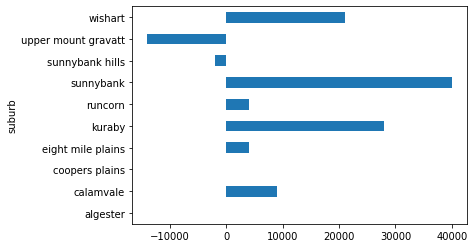

In [36]:
#REA House Median Price - 4 bedroms
rea_bdr4=rea_bdrs.loc[('house','4')]

#Domain House Median Price - 4 bedroms
domain_bdr4=domain_bdrs.loc[('house', 4)]

#compare the House Median Price between 4 bedrooms (REA vs Domain)
median_price_diff4=rea_bdr4-domain_bdr4
median_price_diff4.plot(kind='barh')

### Compare Website Traffic and Overall Rating
<font color='blue'>We will quickly compare these 2 sites on the following metrics to help us make an informed decision:</font>

-- 1 Website Traffic & Other KPIs (Unique Visitors, Visits, Time Spent per Visit, Bounce Rate) -SEMRUSH www.semrush.com<br>
-- 2 Overall site rating - Canstar https://www.canstarblue.com.au/stores-services/real-estate-vs-domain/

Other info: https://community.cubbi.com.au/blog/realestate-com-au-versus-domain-which-site-is-best-to-advertise-my-property

**1) <font color='blue'>Traffic Comparison<font>**

In [37]:
#1. Website Traffic & Other KPI

web_url=r'data\Traffic_Rating.xlsx'

df_web=pd.read_excel(web_url, sheet_name='SEMRUSH_traffic')
df_web

,Domain,Visits (M),Unique Visitors (M),Pages / Visit,Avg. Visit Duration (Mins),Bounce Rate
0,realestate.com.au,50.5,12.3,4.26,10.30,0.3754
1,domain.com.au,16.3,5.8,3.73,12.27,0.5398


<AxesSubplot:>

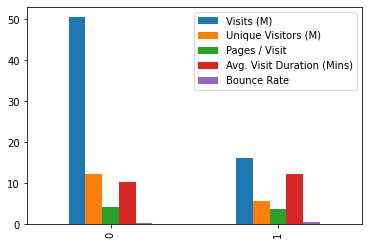

In [38]:
df_web.plot(kind='bar')

**<font color='blue'>Summary<font>**
    
- By comparing the web traffic KPIs, we can see **REA (realestate.com.au) has 8X more traffic** than Domain by **Visits**.
- **REA** also has **2X more traffic** than Domain by **Unique Visitors**.
- Though Domain has slightly higher Avg. Visit Duration length (12 mins) than REA (10 mins), **REA** showed **much lower bounce rate (38%) than Domain (54%)**. This indicates visitors are more likely to stay around and view more than 1 pages on REA.
    
<font color='blue'>In summary - REA has much stronger traffic and also better user engagement than Domain.</font>

**2) <font color='blue'>Site Overall Ratings<font>**

In [39]:
#2. Compare the Site Overall Ratings from Canstar data

df_rating=pd.read_excel(web_url, sheet_name='CANSTAR_rating')
df_rating

,Rated brands,Overall satisfaction,Range of properties,Ease of site navigation,Quality of information available,Image accuracy,Tools and calculators,Total Score
0,realestate.com.au,5,5,5,5,4,5,29
1,domain.com.au,4,4,4,4,4,4,24


In [40]:
#Show the overall rating in colored bar chart

df_total_score=df_rating.iloc[:,-1]
plt.bar(df_rating['Rated brands'],df_rating['Total Score'], color=['#F57D7C', '#6CC2BD'],width=0.4)
plt.xlabel("Sites")
plt.ylabel("Total Score")
plt.title("Total Score - REA vs Domain")

plt.show()

NameError: name 'plt' is not defined

**<font color='blue'>Summary<font>**
    
- By comparing the overall site ratings from Canstar, we can see **REA (realestate.com.au) outranked Domain** by **"Total Score"**.
- REA - total score : 29
- Domain - total score: 24
- REA led the rating in 5 out of 6 categories (Overall satisfaction, Overall satisfaction, Range of properties, Ease of site navigation, Quality of information available and Tools and calculators)
    
<font color='blue'>In summary - REA has a higher overall performance rating than Domain.<font>

### **<font color='blue'>Conclusion</font>**
- Based on the comparisons from web traffic and overall site performance overview of 2 sites,<br>
it's clear that **REA** is the site that we would go for more detailed property data analysis. 

Next Step
- Scrap the property listing of the 10 suburbs from REA site

# <font color='#0366d6'> REA Property Data Analysis </font>

Note:
- I used a web scraping tool to obtain the property listing data from the 10 suburbs to speed up the process.<br>
- Let's import the data from domain.com.au and have a preview.

## Combine files and create a dataframe for all suburbs

Import the scraped 10 suburbs property listings data from RAE with a loop and combine the files into a single dataframe

We will take the following steps to read in multiple files
1. Get a list of filenames (or sheets)
2. Turn those into a list of dataframes
3. Add the filename as a column to each dataframe
4. Combine the dataframes into one big dataframe


In [41]:
#Getting a list of filenames

filenames=glob.glob('Data\\realestate.com.au_SOLD*.csv')
filenames

['Data\\realestate.com.au_SOLD_Algester.csv',
 'Data\\realestate.com.au_SOLD_Calamvale.csv',
 'Data\\realestate.com.au_SOLD_Coopers_Plains.csv',
 'Data\\realestate.com.au_SOLD_Eight_Mile_Plains.csv',
 'Data\\realestate.com.au_SOLD_Kuraby.csv',
 'Data\\realestate.com.au_SOLD_Runcorn.csv',
 'Data\\realestate.com.au_SOLD_Sunnybank.csv',
 'Data\\realestate.com.au_SOLD_Sunnybank_Hills.csv',
 'Data\\realestate.com.au_SOLD_Upper_Mt_Gravatt.csv',
 'Data\\realestate.com.au_SOLD_Wishart.csv']

In [42]:
#Turn those files into a list of dataframes
df_lists=[pd.read_csv(filename, encoding='ISO-8859-1') for filename in filenames]
len(df_lists)

10

In [43]:
#Combining multiple dataframes
df_all=pd.concat(df_lists, ignore_index=True)
df_all.shape #check dataframe shape

(9993, 14)

In [44]:
#preview the dataframe
df_all.head(3)

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Price,Bedrooms,Bathrooms,Car_park,Size,Size_unit,Type,Sold_date
0,"58 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/d4ded41d266...,Michelle Huston & Mark Kearns,https://i2.au.reastatic.net/150x200/8a5badd53f...,Sold,"$700,000",2.0,2.0,2.0,549,m²,House,Sold on 15 Dec 2020
1,"162 Delathin Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,JJ Macalino,https://i2.au.reastatic.net/150x200/ff4dfb2ff3...,Sold,"$600,000",4.0,2.0,2.0,570,m²,House,Sold on 11 Dec 2020
2,"20 Springwater Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,"$577,800",4.0,3.0,2.0,604,m²,House,Sold on 11 Dec 2020


In [45]:
# there are 4 addresses contain ",,", 
#which will break the split function to be used to extract Suburb name, let's replace them with ",".

df_all['Address']=df_all['Address'].str.strip().str.replace(",,", ",") 

In [46]:
#extract the Suburb name from the df_all, and add a new column as "Surburb"

df_all['Suburb']=df_all['Address'].str.split(',', expand=True)[1].str.strip() 

In [47]:
#Split the Suburb string and to extract the last item as the Suburb name
df_all['Suburb']=[row[-1] for row in df_all['Address'].str.split(',')]

In [48]:
#Check the suburbs names
df_all['Suburb'].value_counts()

 Sunnybank              1500
 Sunnybank Hills        1250
 Algester               1250
 Eight Mile Plains      1250
 Kuraby                 1075
 Wishart                1026
 Upper Mount Gravatt    1000
 Coopers Plains          696
 Calamvale               550
 Runcorn                 396
Name: Suburb, dtype: int64

- When checking the data types in the data frame, there are some duplicates and missing values across multiple columns.
- We can also see the Price, Size are of the string type (instead of numeric values)
- Furthermore, the Sold_date is string type instead of datetime type. 
- So the tasks to perform next are to remove duplicates, fill the missing values, convert Price and Size dtypes to float64 and turn Sold_date to datetime type.

In [49]:
#check the data types
df_all.dtypes

Address           object
Property_Info     object
Agent_logo        object
Agent             object
Agent_photo       object
Status            object
Price             object
Bedrooms         float64
Bathrooms        float64
Car_park         float64
Size              object
Size_unit         object
Type              object
Sold_date         object
Suburb            object
dtype: object

In [50]:
df_all.isna().sum()/len(df_all)*100 #check the missing values in each column by %

Address           0.000000
Property_Info     0.000000
Agent_logo       10.387271
Agent            46.922846
Agent_photo      64.535175
Status            0.000000
Price             0.000000
Bedrooms          2.952066
Bathrooms         2.952066
Car_park          5.273692
Size             21.985390
Size_unit        20.074052
Type              0.000000
Sold_date         0.060042
Suburb            0.000000
dtype: float64

In [51]:
#check the df shape
df_all.shape

(9993, 15)

## Data cleansing first

### Drop duplicates

In [52]:
df_all.duplicated().sum()

87

In [53]:
df_all.drop_duplicates(keep='first', inplace=True)
df_all.shape

(9906, 15)

In [54]:
df_all.drop_duplicates(subset=['Address'], keep='first', inplace=True)
df_all.shape

(8588, 15)

### Convert " Price, Size" columns to numeric datatype

In [55]:
# Check the Price column and we can see 2 issues:
# - there are 5% of total rows showing "Contact agent", so we can't evaluate the house price in this case
# - there's a dollar sign in the price column
    
df_all['Price'].value_counts(normalize=True)

Contact agent    0.052632
$650,000         0.006754
$550,000         0.006404
$400,000         0.006055
$750,000         0.005589
                   ...   
$703,500         0.000116
$1,285,000       0.000116
$316,500         0.000116
$910,000         0.000116
$870,600         0.000116
Name: Price, Length: 2059, dtype: float64

In [56]:
#drop the rows where Price shown as "Contact agent"

df_all=df_all[df_all['Price']!='Contact agent']
df_all.shape  #we have dropped 452 rows

(8136, 15)

In [57]:
df_all['Size'].isna().sum() #Size column has~1.8K rows has no value

1784

In [58]:
df_all['Size']=df_all['Size'].fillna(0) #Fill the null value with 0 
df_all['Size'].isna().sum()  #Now, the Size column doesn't have any null value

0

In [59]:
#Remove the dollar $ from Price, so we can convert Price and Size into numeric values using the "remove_puncs function"

str_cols=['Price', 'Size']
num_cols=defaultdict(pd.Series)

for c in str_cols:
    num_cols[c]=df_all[c].apply(lambda i:pd.to_numeric(remove_puncs(i), 'coerce')).astype(np.float64)

In [60]:
num_cols.keys()

dict_keys(['Price', 'Size'])

In [61]:
df_all=df_all.drop(list(num_cols.keys()), axis=1) #drop the 2 original columns - Price and Size
df_all.head()

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb
0,"58 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/d4ded41d266...,Michelle Huston & Mark Kearns,https://i2.au.reastatic.net/150x200/8a5badd53f...,Sold,2.0,2.0,2.0,m²,House,Sold on 15 Dec 2020,Algester
1,"162 Delathin Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,JJ Macalino,https://i2.au.reastatic.net/150x200/ff4dfb2ff3...,Sold,4.0,2.0,2.0,m²,House,Sold on 11 Dec 2020,Algester
2,"20 Springwater Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,3.0,2.0,m²,House,Sold on 11 Dec 2020,Algester
3,"8 Limewood Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,Gonnie Nahar,https://i2.au.reastatic.net/150x200/4b77daff58...,Sold,3.0,1.0,3.0,m²,House,Sold on 08 Dec 2020,Algester
4,"27 Owenia Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,2.0,2.0,m²,House,Sold on 04 Dec 2020,Algester


In [62]:
df_all=df_all.assign(**num_cols) #reassign processed columns back to the dataframe
df_all.head()

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb,Price,Size
0,"58 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/d4ded41d266...,Michelle Huston & Mark Kearns,https://i2.au.reastatic.net/150x200/8a5badd53f...,Sold,2.0,2.0,2.0,m²,House,Sold on 15 Dec 2020,Algester,700000.0,549.0
1,"162 Delathin Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,JJ Macalino,https://i2.au.reastatic.net/150x200/ff4dfb2ff3...,Sold,4.0,2.0,2.0,m²,House,Sold on 11 Dec 2020,Algester,600000.0,570.0
2,"20 Springwater Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,3.0,2.0,m²,House,Sold on 11 Dec 2020,Algester,577800.0,604.0
3,"8 Limewood Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,Gonnie Nahar,https://i2.au.reastatic.net/150x200/4b77daff58...,Sold,3.0,1.0,3.0,m²,House,Sold on 08 Dec 2020,Algester,515100.0,597.0
4,"27 Owenia Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,2.0,2.0,m²,House,Sold on 04 Dec 2020,Algester,546500.0,639.0


In [63]:
#Fix the remained price and size issues

# For example, the Price value low (407) or too high.
# Some of the house size was under 2 mm2, because they were measured in HA.
# Some of the property listed as House but the size showed and address info showed they are actually Townhouses.

In [64]:
sorted(df_all.Price.value_counts().index)
#check the lowest price 407
df_all[df_all.Price==407]

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb,Price,Size
9783,"10 Winthrop, Wishart",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/6771cd17f45...,Agent: William Hooper,NaN,Sold,4.0,1.0,2.0,NaN,House,Sold on 20 Mar 2013,Wishart,407.0,NaN


In [65]:
#Update the crazy price value/size value to the correct data
df_all.at[9783,'Price']=515000

df_all.at[4772,'Price']=640000

df_all.at[2471,'Price']=332000

df_all.at[2495,'Price']=546000

df_all.at[4642,'Price']=640000

df_all.at[4684,'Price']=580000

df_all.at[4689,'Price']=415000

df_all.at[4710,'Price']=526000

df_all.at[4772,'Price']=640000

df_all.at[4684,'Size']=451

In [66]:
df_all.dtypes

Address           object
Property_Info     object
Agent_logo        object
Agent             object
Agent_photo       object
Status            object
Bedrooms         float64
Bathrooms        float64
Car_park         float64
Size_unit         object
Type              object
Sold_date         object
Suburb            object
Price            float64
Size             float64
dtype: object

In [67]:
#Updated the size to mm2

df_all.Size=[x*10000 if x <=2 else x+0 for x in df_all.Size]

In [68]:
#Now we see from the address that some of the houses with land size under 200 are actually Townhouses.
#So let's update them to the correct property type.

df_townhouse=df_all[(df_all.Size<=200)&(df_all['Type']=='House')]
df_townhouse[:3]

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb,Price,Size
323,"4/157 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/91a8160f9d1...,EMMA WALTER,https://i2.au.reastatic.net/150x200/e4191f782b...,Sold,3.0,2.0,1.0,m²,House,Sold on 05 Jun 2017,Algester,316000.0,163.0
344,"8/72 Learoyd Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/3fbb0a1151f...,NaN,NaN,Sold,4.0,2.0,2.0,m²,House,Sold on 15 Feb 2017,Algester,315000.0,94.0
390,"24/18 Ackama Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/3fbb0a1151f...,NaN,NaN,Sold,3.0,2.0,1.0,m²,House,Sold on 11 Jul 2016,Algester,307000.0,173.0


In [69]:
#We will update the property type to Townhouse if the type = House, and the size is <= 200, also the address contains "/"

th_index=df_all[(df_all.Size<=200)&(df_all['Type']=='House')].Address.str.contains('/').index
th_index

for ind in th_index:
    df_all.at[ind,'Type']='Townhouse'

### Convert column "Sold_date" to datetime type

In [70]:
#less than 1 % of the Sold_date value are missing, we can drop those rows as well

df_all.dropna(axis=0,subset=['Sold_date'], inplace=True) 
df_all=df_all.reset_index(drop=True)
df_all.head()

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb,Price,Size
0,"58 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/d4ded41d266...,Michelle Huston & Mark Kearns,https://i2.au.reastatic.net/150x200/8a5badd53f...,Sold,2.0,2.0,2.0,m²,House,Sold on 15 Dec 2020,Algester,700000.0,549.0
1,"162 Delathin Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,JJ Macalino,https://i2.au.reastatic.net/150x200/ff4dfb2ff3...,Sold,4.0,2.0,2.0,m²,House,Sold on 11 Dec 2020,Algester,600000.0,570.0
2,"20 Springwater Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,3.0,2.0,m²,House,Sold on 11 Dec 2020,Algester,577800.0,604.0
3,"8 Limewood Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,Gonnie Nahar,https://i2.au.reastatic.net/150x200/4b77daff58...,Sold,3.0,1.0,3.0,m²,House,Sold on 08 Dec 2020,Algester,515100.0,597.0
4,"27 Owenia Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,2.0,2.0,m²,House,Sold on 04 Dec 2020,Algester,546500.0,639.0


In [71]:
df_all['Sold_date']=df_all['Sold_date'].str.replace('Sold on ', '') #remove the text "Sold on"
df_all.Sold_date=pd.to_datetime(df_all.Sold_date) #conver the Sold_date into datetime type 

In [72]:
Sold_year=df_all['Sold_date'].dt.year #extract year from the Sold_date
df_all['Sold_year']=Sold_year #assign the new Sold_year column back to df_all

In [73]:
df_all['Sold_year'].astype(np.int64) #convert year datatype to integer

0       2020
1       2020
2       2020
3       2020
4       2020
        ... 
8126    2015
8127    2015
8128    2015
8129    2015
8130    2014
Name: Sold_year, Length: 8131, dtype: int64

### Fill the missing values in any other columns 

In [74]:
#3 columns - 'Agent_logo', 'Agent', 'Agent_photo', we can simply fill the cell with "unknown"

agent_cols=['Agent_logo', 'Agent', 'Agent_photo']
for agent in agent_cols:
    df_all[agent]=df_all[agent].fillna('unknown')

In [75]:
#Column - "Size_unit" , we know all the landsize was measured by m², so we can fill all missing values with m²

df_all['Size_unit']='m²'

In [76]:
# 2 Columns - "Bedrooms" and "Bathrooms" has ~3% missing values each, as we need the Bedroom num to compare the price, and the missing value means
#these rows of data may not be useful for us. So we can drop them.

df_all.dropna(axis=0, subset=['Bedrooms', 'Bathrooms'], inplace=True)
df_all.shape

(7932, 16)

In [77]:
# Column - "Car_park", we can fill the missing value with 0, as this is not so important in this case

df_all['Car_park'].fillna(0, inplace=True)

In [78]:
#Column - "Type" - we see "Apartment", "Unit" are listed seperatedly. As we are more interested in House type, let's combined these 2 types into "Unit"
df_all['Type'].value_counts()

House                   6317
Townhouse               1232
Apartment                143
Unit                     136
Villa                     78
Block Of Units             7
Duplex/Semi-Detached       5
Other                      5
Retirement Living          4
Acreage                    3
Terrace                    1
Warehouse                  1
Name: Type, dtype: int64

In [79]:
apt=df_all['Type']=='Apartment'
df_all['Type'].copy()[apt]='Unit'
df_all['Type'].value_counts()

House                   6317
Townhouse               1232
Apartment                143
Unit                     136
Villa                     78
Block Of Units             7
Duplex/Semi-Detached       5
Other                      5
Retirement Living          4
Acreage                    3
Terrace                    1
Warehouse                  1
Name: Type, dtype: int64

In [80]:
#check if there are any other columns still have missing values
df_all['Size']=df_all['Size'].fillna(0)
df_all.isnull().sum()

Address          0
Property_Info    0
Agent_logo       0
Agent            0
Agent_photo      0
Status           0
Bedrooms         0
Bathrooms        0
Car_park         0
Size_unit        0
Type             0
Sold_date        0
Suburb           0
Price            0
Size             0
Sold_year        0
dtype: int64

In [81]:
#fix the suburb
df_all.Suburb.value_counts()

 Eight Mile Plains      1139
 Sunnybank Hills        1125
 Algester               1011
 Upper Mount Gravatt     894
 Wishart                 878
 Sunnybank               738
 Kuraby                  717
 Calamvale               535
 Coopers Plains          502
 Runcorn                 393
Name: Suburb, dtype: int64

In [82]:
df_all.to_csv("df_all_10.csv", index=False)
df_all.shape

(7932, 16)

In [83]:
df_all.head()

,Address,Property_Info,Agent_logo,Agent,Agent_photo,Status,Bedrooms,Bathrooms,Car_park,Size_unit,Type,Sold_date,Suburb,Price,Size,Sold_year
0,"58 Dalmeny Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/d4ded41d266...,Michelle Huston & Mark Kearns,https://i2.au.reastatic.net/150x200/8a5badd53f...,Sold,2.0,2.0,2.0,m²,House,2020-12-15,Algester,700000.0,549.0,2020
1,"162 Delathin Road, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,JJ Macalino,https://i2.au.reastatic.net/150x200/ff4dfb2ff3...,Sold,4.0,2.0,2.0,m²,House,2020-12-11,Algester,600000.0,570.0,2020
2,"20 Springwater Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,3.0,2.0,m²,House,2020-12-11,Algester,577800.0,604.0,2020
3,"8 Limewood Place, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/72065f86a98...,Gonnie Nahar,https://i2.au.reastatic.net/150x200/4b77daff58...,Sold,3.0,1.0,3.0,m²,House,2020-12-08,Algester,515100.0,597.0,2020
4,"27 Owenia Street, Algester",https://www.realestate.com.au/sold/property-ho...,https://i2.au.reastatic.net/340x64/adf93bc0d60...,Andrea Manson,https://i2.au.reastatic.net/150x200/d84dba8712...,Sold,4.0,2.0,2.0,m²,House,2020-12-04,Algester,546500.0,639.0,2020


The final cleaned data is stored in the df_all_10.csv file, which can be accessed through [this link](https://docs.google.com/spreadsheets/d/1iIhILDvN8bh42oT4sKpx7B-9ATjbD1CF0CAeOTHci94/edit?usp=sharing)